# 🧠 Goalkeeper Position LSTM Model
This notebook trains an LSTM on known goalkeeper positions and predicts missing ones from new CSVs.

## 📦 1. Setup & Upload
Install dependencies and upload your training file (should have full position data).

In [ ]:
!pip install torch pandas matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded_train = files.upload()

Saving gk_2_positions_train.csv to gk_2_positions_train.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

filename = list(uploaded_train.keys())[0]
df = pd.read_csv(filename)
df.columns = df.columns.str.strip()
df['gk2_x'] = pd.to_numeric(df['gk2_x'], errors='coerce')
df['gk2_y'] = pd.to_numeric(df['gk2_y'], errors='coerce')

## 🏋️‍♂️ 2. Define & Train LSTM Model
Train on full data where goalkeeper positions are known.

In [ ]:
class PositionPredictor(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2):
        super(PositionPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

In [ ]:
SEQ_LEN = 10
gk_df = df[['gk2_x', 'gk2_y']].dropna().copy()
gk_df.columns = ['x', 'y']

mean = gk_df.mean()
std = gk_df.std()
norm_data = (gk_df - mean) / std

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data.iloc[i:i+seq_len].values)
        y.append(data.iloc[i+seq_len].values)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = create_sequences(norm_data, SEQ_LEN)

model = PositionPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

<ipython-input-6-5d7d103e0c45>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Epoch 0, Loss: 0.5372
Epoch 10, Loss: 0.3109
Epoch 20, Loss: 0.2137
Epoch 30, Loss: 0.1850
Epoch 40, Loss: 0.1742
Epoch 50, Loss: 0.1705
Epoch 60, Loss: 0.1657
Epoch 70, Loss: 0.1568
Epoch 80, Loss: 0.1336
Epoch 90, Loss: 0.0971


## 🧪 3. Predict Missing Positions in New File
Upload a CSV that has some missing GK positions.

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import torch

# Upload and load the test file
uploaded = files.upload()
test_filename = list(uploaded.keys())[0]
test_df = pd.read_csv(test_filename)

# Ensure clean column names
test_df.columns = test_df.columns.str.strip()
df = test_df.rename(columns={'gk2_x': 'x', 'gk2_y': 'y'})  # adjust this if different

# Normalize
norm_df = (df[['x', 'y']] - mean) / std
norm_np = norm_df.values

# Initialize predictions
df['x_pred'] = np.nan
df['y_pred'] = np.nan

# Predict only when values are missing
sequence = norm_np[-SEQ_LEN:]  # get the last SEQ_LEN rows
seq_tensor = torch.tensor([sequence], dtype=torch.float32)
with torch.no_grad():
    pred = model(seq_tensor).numpy()[0]
# De-normalize
denorm_pred = pred * std.values[:2] + mean.values[:2]

# Append new predicted row
new_row = {
    'x': np.nan, 'y': np.nan,  # mark as unknown true value
    'x_pred': denorm_pred[0],
    'y_pred': denorm_pred[1]
}
df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

# Save result
df.to_csv("filled_predictions.csv", index=False)
print("✅ Saved filled_predictions.csv (only missing positions are predicted)")

Saving gk_2_positions_test.csv to gk_2_positions_test (1).csv
✅ Saved filled_predictions.csv (only missing positions are predicted)


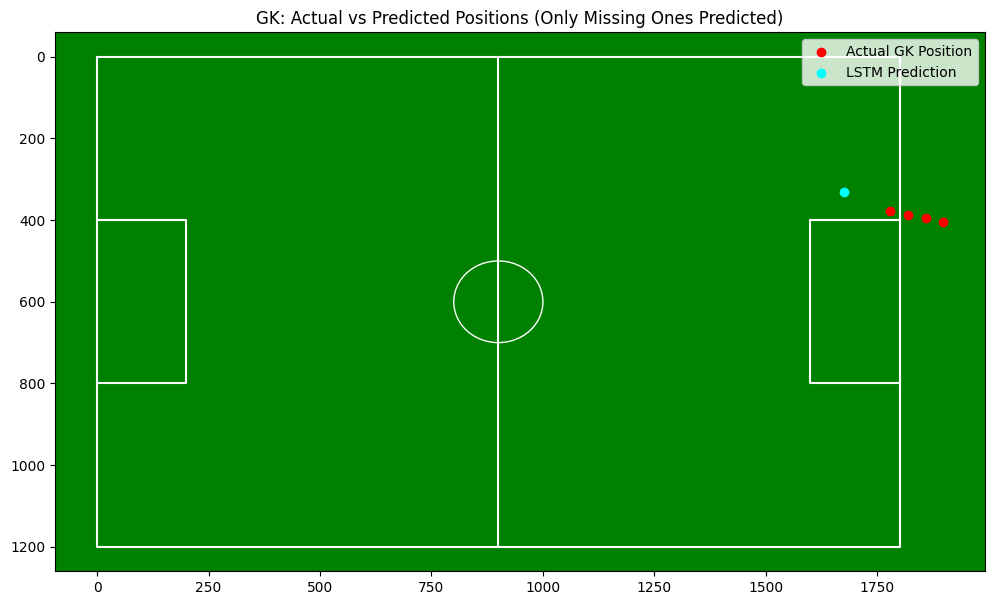

In [ ]:
import matplotlib.pyplot as plt

def draw_pitch():
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_facecolor('green')
    plt.plot([0, 0, 1800, 1800, 0], [0, 1200, 1200, 0, 0], color="white")
    plt.plot([900, 900], [0, 1200], color="white")
    plt.plot([0, 200, 200, 0], [400, 400, 800, 800], color="white")  # left goal
    plt.plot([1800, 1600, 1600, 1800], [400, 400, 800, 800], color="white")  # right goal
    circle = plt.Circle((900, 600), 100, color='white', fill=False)
    ax.add_patch(circle)
    return ax

# Load predictions
df = pd.read_csv("filled_predictions.csv")

# Plot
ax = draw_pitch()
# Actual known positions
mask_actual = ~df['x'].isna()
ax.scatter(df.loc[mask_actual, 'x'], df.loc[mask_actual, 'y'], c='red', label='Actual GK Position')
# Predicted (missing) positions
mask_pred = df['x_pred'].notna()
ax.scatter(df.loc[mask_pred, 'x_pred'], df.loc[mask_pred, 'y_pred'], c='cyan', label='LSTM Prediction')

plt.legend()
plt.title("GK: Actual vs Predicted Positions (Only Missing Ones Predicted)")
plt.gca().invert_yaxis()
plt.show()
